# Лабораторная работа 2  
Решение СЛАУ итерационными и прямыми методами

---

## Методы решения СЛАУ

В работе для одной и той же системы \( A x = f \) использую:

- метод Гаусса с выбором главного элемента;
- метод \(LU\)-разложения;
- метод Якоби;
- метод Зейделя;
- метод верхней релаксации (SOR);
- метод градиентного спуска;
- метод минимальных невязок;
- стабилизированный метод бисопряжённых градиентов (BiCGSTAB).

---

## Используемые нормы

**Норма 1**

$$
\|u\|_1 = \max_{1 \le i \le n} |u_i|,
\qquad
\|A\|_1 = \max_{1 \le i \le n} \sum_{j=1}^n |a_{ij}|.
$$

**Норма 2**

$$
\|u\|_2 = \sum_{j=1}^{n} |u_j|,
\qquad
\|A\|_2 = \max_{1 \le j \le n} \sum_{i=1}^{n} |a_{ij}|.
$$

**Норма 3**

$$
\|u\|_3 = \sqrt{(u,u)},
\qquad
\|A\|_3 = \sqrt{\max_{1 \le i \le n} \lambda_i\bigl(A^\ast A\bigr)}.
$$

---

## Решаемая СЛАУ

Параметры: \( n = 100,\; a = 10,\; b = 10 \).

Система задаётся так:

$$
\begin{cases}
a x_1 + x_2 + \dfrac{x_3}{b} = 1,\\[2mm]
x_1 + a x_2 + x_3 + \dfrac{x_4}{b} = 2,\\[2mm]
x_2 + a x_3 + x_4 + \dfrac{x_5}{b} = 3,\\[2mm]
\vdots \\[1mm]
x_{m-1} + a x_m + x_{m+1} + \dfrac{x_{m+2}}{b} = m,\\[1mm]
\vdots \\[1mm]
x_{n-2} + a x_{n-1} + x_n = n - 1,\\[2mm]
x_{n-1} + a x_n = n.
\end{cases}
$$

Дальше систему записываю в матричном виде \( A x = f \)  
и к ней последовательно применяю все перечисленные выше методы.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Построение матрицы A и вектора f

def build_system(n=100, a=10.0, b=10.0):
    A = np.zeros((n, n), dtype=float)
    f = np.arange(1, n + 1, dtype=float)  # правая часть: 1, 2, 3, ..., n

    # первая строка: a x1 + x2 + x3/b = 1
    A[0, 0] = a
    A[0, 1] = 1.0
    A[0, 2] = 1.0 / b

    # внутренние строки с шаблоном
    for i in range(1, n - 2):  # от второй до предпоследней-1
        A[i, i - 1] = 1.0
        A[i, i] = a
        A[i, i + 1] = 1.0
        if i + 2 < n:
            A[i, i + 2] = 1.0 / b

    # строка с x_{n-2} + a x_{n-1} + x_n = n-1
    A[n - 2, n - 3] = 1.0
    A[n - 2, n - 2] = a
    A[n - 2, n - 1] = 1.0

    # последняя строка: x_{n-1} + a x_n = n
    A[n - 1, n - 2] = 1.0
    A[n - 1, n - 1] = a

    return A, f


A, f = build_system()
n = A.shape[0]

print(f"Размерность системы: n = {n}")
print("Первые 5 строк матрицы A (первые 10 столбцов):")
print(A[:5, :10])
print("Первые 10 элементов правой части f:", f[:10])


Размерность системы: n = 100
Первые 5 строк матрицы A (первые 10 столбцов):
[[10.   1.   0.1  0.   0.   0.   0.   0.   0.   0. ]
 [ 1.  10.   1.   0.1  0.   0.   0.   0.   0.   0. ]
 [ 0.   1.  10.   1.   0.1  0.   0.   0.   0.   0. ]
 [ 0.   0.   1.  10.   1.   0.1  0.   0.   0.   0. ]
 [ 0.   0.   0.   1.  10.   1.   0.1  0.   0.   0. ]]
Первые 10 элементов правой части f: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


In [3]:
# Нормы и вспомогательные функции

def norm1(v):
    return np.linalg.norm(v, 1)

def norm_inf(v):
    return np.linalg.norm(v, np.inf)

def norm2(v):
    """Евклидова норма вектора."""
    return np.linalg.norm(v)

def residual(A, x, f):
    """Невязка r = f - Ax."""
    return f - A @ x

def print_residuals(name, A, x, f):
    """Красивый вывод невязки в трёх нормах."""
    r = residual(A, x, f)
    print(
        f"{name:15s}"
        f" ||r||₁ = {norm1(r):.3e},"
        f" ||r||₂ = {norm2(r):.3e},"
        f" ||r||∞ = {norm_inf(r):.3e}"
    )

In [4]:
# Прямые методы: Гаусс с выбором главного элемента

def gauss_partial_pivot(A, f):
    A = A.copy().astype(float)
    b = f.copy().astype(float)
    n = len(b)

    for k in range(n - 1):
        pivot = k + np.argmax(np.abs(A[k:, k]))
        if A[pivot, k] == 0:
            raise ValueError("Нулевой ведущий элемент")
        if pivot != k:
            A[[k, pivot]] = A[[pivot, k]]
            b[[k, pivot]] = b[[pivot, k]]

        for i in range(k + 1, n):
            factor = A[i, k] / A[k, k]
            A[i, k:] -= factor * A[k, k:]
            b[i] -= factor * b[k]

    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        s = np.dot(A[i, i + 1:], x[i + 1:])
        x[i] = (b[i] - s) / A[i, i]

    return x

x_gauss = gauss_partial_pivot(A, f)
print_residuals("Гаусс", A, x_gauss, f)

Гаусс           ||r||₁ = 3.493e-13, ||r||₂ = 6.994e-14, ||r||∞ = 2.842e-14


In [5]:
# Прямые методы: LU-разложение (без перестановок)

def lu_decomposition(A):
    """Doolittle: A = L U, diag(L) = 1."""
    A = A.copy().astype(float)
    n = A.shape[0]
    L = np.zeros_like(A)
    U = np.zeros_like(A)

    for i in range(n):
        for k in range(i, n):
            U[i, k] = A[i, k] - np.dot(L[i, :i], U[:i, k])
        L[i, i] = 1.0
        for k in range(i + 1, n):
            L[k, i] = (A[k, i] - np.dot(L[k, :i], U[:i, i])) / U[i, i]
    return L, U

def forward_substitution(L, b):
    n = len(b)
    y = np.zeros(n)
    for i in range(n):
        y[i] = b[i] - np.dot(L[i, :i], y[:i])
    return y

def back_substitution(U, y):
    n = len(y)
    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        x[i] = (y[i] - np.dot(U[i, i + 1:], x[i + 1:])) / U[i, i]
    return x

L, U = lu_decomposition(A)
y = forward_substitution(L, f)
x_lu = back_substitution(U, y)

print_residuals("LU", A, x_lu, f)
print("Норма разности решений LU и Гаусса (||x_LU - x_Gauss||₂) =",
      norm2(x_lu - x_gauss))


LU              ||r||₁ = 3.493e-13, ||r||₂ = 6.994e-14, ||r||∞ = 2.842e-14
Норма разности решений LU и Гаусса (||x_LU - x_Gauss||₂) = 0.0


In [6]:
# Итерационные методы (общие параметры)

max_iter = 5000
tol = 1e-10
x0 = np.zeros(n)  # начальное приближение


In [7]:
# Метод Якоби

def jacobi(A, f, x0, max_iter=1000, tol=1e-10):
    n = len(f)
    x = x0.copy()
    x_new = np.zeros_like(x)
    res_hist = []

    for k in range(max_iter):
        for i in range(n):
            s = np.dot(A[i, :i], x[:i]) + np.dot(A[i, i + 1:], x[i + 1:])
            x_new[i] = (f[i] - s) / A[i, i]

        r = residual(A, x_new, f)
        res = norm2(r)
        res_hist.append(res)
        if res < tol:
            break

        x[:] = x_new

    return x_new, res_hist

x_jacobi, hist_jacobi = jacobi(A, f, x0, max_iter, tol)
print("Якоби: итераций =", len(hist_jacobi))
print_residuals("Якоби", A, x_jacobi, f)


Якоби: итераций = 19
Якоби           ||r||₁ = 6.357e-10, ||r||₂ = 7.223e-11, ||r||∞ = 1.172e-11


In [8]:
# Метод Зейделя (Gauss–Seidel)

def gauss_seidel(A, f, x0, max_iter=1000, tol=1e-10):
    n = len(f)
    x = x0.copy()
    res_hist = []

    for k in range(max_iter):
        for i in range(n):
            s1 = np.dot(A[i, :i], x[:i])
            s2 = np.dot(A[i, i + 1:], x[i + 1:])
            x[i] = (f[i] - s1 - s2) / A[i, i]

        r = residual(A, x, f)
        res = norm2(r)
        res_hist.append(res)
        if res < tol:
            break

    return x, res_hist

x_gs, hist_gs = gauss_seidel(A, f, x0, max_iter, tol)
print("Зейдель: итераций =", len(hist_gs))
print_residuals("Зейдель", A, x_gs, f)


Зейдель: итераций = 13
Зейдель         ||r||₁ = 5.040e-10, ||r||₂ = 5.806e-11, ||r||∞ = 9.720e-12


In [9]:
# Метод верхней релаксации (SOR)

def sor(A, f, x0, omega, max_iter=1000, tol=1e-10):
    n = len(f)
    x = x0.copy()
    res_hist = []

    for k in range(max_iter):
        for i in range(n):
            s1 = np.dot(A[i, :i], x[:i])
            s2 = np.dot(A[i, i + 1:], x[i + 1:])
            x_i_new = (f[i] - s1 - s2) / A[i, i]
            x[i] = x[i] + omega * (x_i_new - x[i])

        r = residual(A, x, f)
        res = norm2(r)
        res_hist.append(res)
        if res < tol:
            break

    return x, res_hist

omegas = [0.8, 1.0, 1.2, 1.5]
sor_results = {}
for w in omegas:
    x_sor, hist_sor = sor(A, f, x0, omega=w, max_iter=max_iter, tol=tol)
    sor_results[w] = (x_sor, hist_sor)
    print(f"SOR, ω={w}: итераций = {len(hist_sor)}, ||r||₂ = {hist_sor[-1]}")
    print_residuals(f"SOR ω={w}", A, x_sor, f)


SOR, ω=0.8: итераций = 21, ||r||₂ = 8.007395752505155e-11
SOR ω=0.8       ||r||₁ = 1.978e-10, ||r||₂ = 8.007e-11, ||r||∞ = 4.300e-11
SOR, ω=1.0: итераций = 13, ||r||₂ = 5.805579483839905e-11
SOR ω=1.0       ||r||₁ = 5.040e-10, ||r||₂ = 5.806e-11, ||r||∞ = 9.720e-12
SOR, ω=1.2: итераций = 25, ||r||₂ = 3.585327224481667e-11
SOR ω=1.2       ||r||₁ = 3.123e-10, ||r||₂ = 3.585e-11, ||r||∞ = 5.869e-12
SOR, ω=1.5: итераций = 54, ||r||₂ = 8.115423855634997e-11
SOR ω=1.5       ||r||₁ = 6.922e-10, ||r||₂ = 8.115e-11, ||r||∞ = 1.319e-11


In [10]:
# Метод градиентного спуска

def gradient_descent(A, f, x0, max_iter=1000, tol=1e-10):
    x = x0.copy()
    res_hist = []

    for k in range(max_iter):
        r = f - A @ x
        res = norm2(r)
        res_hist.append(res)
        if res < tol:
            break
        Ar = A @ r
        alpha = (r @ r) / (r @ Ar)
        x = x + alpha * r

    return x, res_hist

x_gd, hist_gd = gradient_descent(A, f, x0, max_iter, tol)
print("Градиентный спуск: итераций =", len(hist_gd))
print_residuals("Град. спуск", A, x_gd, f)


Градиентный спуск: итераций = 17
Град. спуск     ||r||₁ = 2.115e-10, ||r||₂ = 2.720e-11, ||r||∞ = 1.124e-11


In [11]:
# Метод минимальных невязок

def minimal_residual(A, f, x0, max_iter=1000, tol=1e-10):
    x = x0.copy()
    res_hist = []

    for k in range(max_iter):
        r = f - A @ x
        res = norm2(r)
        res_hist.append(res)
        if res < tol:
            break
        Ar = A @ r
        tau = (Ar @ r) / (Ar @ Ar)
        x = x + tau * r

    return x, res_hist

x_mr, hist_mr = minimal_residual(A, f, x0, max_iter, tol)
print("Минимальные невязки: итераций =", len(hist_mr))
print_residuals("Мин. невязок", A, x_mr, f)


Минимальные невязки: итераций = 17
Мин. невязок    ||r||₁ = 1.895e-10, ||r||₂ = 2.610e-11, ||r||∞ = 1.172e-11


In [12]:
# Метод сопряжённых градиентов (для нашей матрицы просто применяем как есть)

def conjugate_gradient(A, f, x0, max_iter=1000, tol=1e-10):
    x = x0.copy()
    r = f - A @ x
    p = r.copy()
    res_hist = [norm2(r)]

    for k in range(max_iter):
        Ap = A @ p
        alpha = (r @ r) / (p @ Ap)
        x = x + alpha * p
        r_new = r - alpha * Ap
        res = norm2(r_new)
        res_hist.append(res)
        if res < tol:
            break
        beta = (r_new @ r_new) / (r @ r)
        p = r_new + beta * p
        r = r_new

    return x, res_hist

x_cg, hist_cg = conjugate_gradient(A, f, x0, max_iter, tol)
print("CG: итераций =", len(hist_cg))
print_residuals("CG", A, x_cg, f)


CG: итераций = 14
CG              ||r||₁ = 7.281e-11, ||r||₂ = 2.072e-11, ||r||∞ = 1.043e-11


In [13]:
# BiCGSTAB (стабилизированный бисопряжённый градиент)

def bicgstab(A, f, x0, max_iter=1000, tol=1e-10):
    n = len(f)
    x = x0.copy()
    r = f - A @ x
    r_hat = r.copy()
    rho_prev = alpha = omega = 1.0
    v = np.zeros(n)
    p = np.zeros(n)
    res_hist = [norm2(r)]

    for k in range(max_iter):
        rho = r_hat @ r
        if abs(rho) < 1e-20:
            break
        if k == 0:
            p = r.copy()
        else:
            beta = (rho / rho_prev) * (alpha / omega)
            p = r + beta * (p - omega * v)

        v = A @ p
        alpha = rho / (r_hat @ v)
        s = r - alpha * v
        s_norm = norm2(s)
        if s_norm < tol:
            x = x + alpha * p
            res_hist.append(s_norm)
            break

        t = A @ s
        omega = (t @ s) / (t @ t)
        x = x + alpha * p + omega * s
        r = s - omega * t
        res = norm2(r)
        res_hist.append(res)
        if res < tol or abs(omega) < 1e-20:
            break

        rho_prev = rho

    return x, res_hist

x_bicg, hist_bicg = bicgstab(A, f, x0, max_iter, tol)
print("BiCGSTAB: итераций =", len(hist_bicg))
print_residuals("BiCGSTAB", A, x_bicg, f)


BiCGSTAB: итераций = 8
BiCGSTAB        ||r||₁ = 2.175e-10, ||r||₂ = 3.891e-11, ||r||∞ = 2.230e-11


In [14]:
# Сравнение с решением Гаусса (по норме разности)

def compare_with_reference(x_ref, **solutions):
    for name, x in solutions.items():
        print(f"{name:15s}  ||x - x_ref||₂ = {norm2(x - x_ref):.3e}")

compare_with_reference(
    x_gauss,
    LU=x_lu,
    Jacobi=x_jacobi,
    Gauss_Seidel=x_gs,
    GD=x_gd,
    MinRes=x_mr,
    CG=x_cg,
    BiCGSTAB=x_bicg,
    SOR_w1_0=sor_results[1.0][0],
)


LU               ||x - x_ref||₂ = 0.000e+00
Jacobi           ||x - x_ref||₂ = 5.973e-12
Gauss_Seidel     ||x - x_ref||₂ = 4.814e-12
GD               ||x - x_ref||₂ = 2.817e-12
MinRes           ||x - x_ref||₂ = 2.803e-12
CG               ||x - x_ref||₂ = 2.016e-12
BiCGSTAB         ||x - x_ref||₂ = 4.255e-12
SOR_w1_0         ||x - x_ref||₂ = 4.814e-12


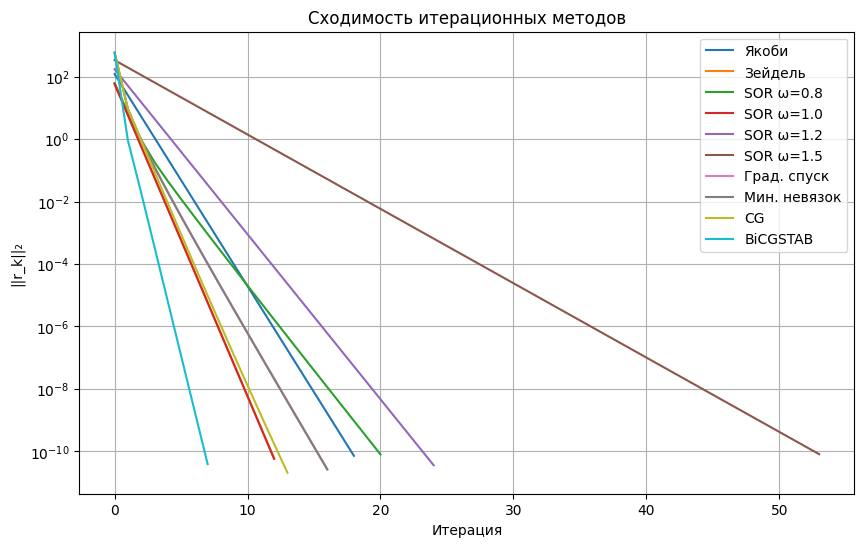

In [15]:
# Графики убывания невязки (логарифмическая шкала по y)

plt.figure(figsize=(10, 6))
plt.semilogy(hist_jacobi, label="Якоби")
plt.semilogy(hist_gs, label="Зейдель")
for w, (_, h) in sor_results.items():
    plt.semilogy(h, label=f"SOR ω={w}")
plt.semilogy(hist_gd, label="Град. спуск")
plt.semilogy(hist_mr, label="Мин. невязок")
plt.semilogy(hist_cg, label="CG")
plt.semilogy(hist_bicg, label="BiCGSTAB")
plt.xlabel("Итерация")
plt.ylabel("||r_k||₂")
plt.grid(True, which="both")
plt.legend()
plt.title("Сходимость итерационных методов")
plt.show()


In [16]:
# Блок 16. Сводная таблица по методам

data = []

def add_row(method_name, x, hist=None):
    iters = len(hist) if hist is not None else 1
    r = residual(A, x, f)
    data.append({
        "Метод": method_name,
        "Итераций": iters,
        "||r||₂": norm2(r),
        "||x - x_Gauss||₂": norm2(x - x_gauss),
    })

add_row("LU", x_lu)
add_row("Якоби", x_jacobi, hist_jacobi)
add_row("Зейдель", x_gs, hist_gs)
add_row("SOR ω=0.8", sor_results[0.8][0], sor_results[0.8][1])
add_row("SOR ω=1.0", sor_results[1.0][0], sor_results[1.0][1])
add_row("SOR ω=1.2", sor_results[1.2][0], sor_results[1.2][1])
add_row("SOR ω=1.5", sor_results[1.5][0], sor_results[1.5][1])
add_row("Град. спуск", x_gd, hist_gd)
add_row("Мин. невязок", x_mr, hist_mr)
add_row("CG", x_cg, hist_cg)
add_row("BiCGSTAB", x_bicg, hist_bicg)

summary_df = pd.DataFrame(data)
summary_df

,Метод,Итераций,||r||₂,||x - x_Gauss||₂
0,LU,1,6.994123e-14,0.000000e+00
1,Якоби,19,7.223429e-11,5.972737e-12
2,Зейдель,13,5.805579e-11,4.814031e-12
3,SOR ω=0.8,21,8.007396e-11,9.736381e-12
4,SOR ω=1.0,13,5.805579e-11,4.814031e-12
5,SOR ω=1.2,25,3.585327e-11,2.965106e-12
6,SOR ω=1.5,54,8.115424e-11,6.710988e-12
7,Град. спуск,17,2.719881e-11,2.816648e-12
8,Мин. невязок,17,2.610070e-11,2.803311e-12
9,CG,14,2.072020e-11,2.016331e-12
